In [65]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.configs import ProjectConfigs, CMORPHConfigs, gSAMConfigs, CERESConfigs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
REGION = 'northwest_tropical_pacific'
GRIDSIZE = 50

In [14]:
era5_pcs = xr.open_dataarray(f'{ProjectConfigs().project_root_dir}/data/era5.pcs.{REGION}.massflux.2deg.nc')
gsam_pcs = xr.open_dataarray(f'{ProjectConfigs().project_root_dir}/data/gsam_era5_levels.pcs.{REGION}.massflux.50pix.nc')
assert((era5_pcs.time==gsam_pcs.time).all())

In [4]:
def compute_mean_pc_tendency(pcs, method='centered', normed=True):
    if normed:
        pcs /= pcs.std(('lat', 'lon', 'time'))
    match method:
        case 'centered':
            delta_pc = pcs.isel(time=slice(2, None)).data - pcs.isel(time=slice(None, -2)).data
            delta_pc = pcs.isel(time=slice(1, -1)).copy(data=delta_pc)
            delta_t = 6
        case 'forward': 
            delta_pc = pcs.isel(time=slice(1, None)).data - pcs.isel(time=slice(None, -1)).data
            delta_pc = pcs.isel(time=slice(None, -1)).copy(data=delta_pc)
            delta_t = 3
        case 'backward':
            delta_pc = pcs.isel(time=slice(1, None)).data - pcs.isel(time=slice(None, -1)).data
            delta_pc = pcs.isel(time=slice(1, None)).copy(data=delta_pc)
            delta_t = 3
        
    return(delta_pc/delta_t)

def bin_stat_by_pcs(pcs, data, pc1_bins, pc2_bins, stat):
    x = pcs.sel(mode=1).data.ravel()
    y = pcs.sel(mode=2).data.ravel()
    out = binned_statistic_2d(y, x, data.data.ravel(), stat, bins=[pc2_bins, pc1_bins]).statistic
    return(out)

# Compare precipitation rates

In [41]:
cmorph = xr.open_dataset(CMORPHConfigs().hourly_2deg)
cmorph = cmorph.cmorph.interp(time=era5_pcs.time)
cmorph = cmorph * 24 # convert to mm/d
assert((gsam_pcs.time==cmorph.time).all())

In [42]:
gsam_precip = xr.open_dataset(gSAMConfigs().coarse_var_dir(REGION, '2D', GRIDSIZE)+'/merged.nc').Prec
gsam_precip

<xarray.DataArray 'Prec' (time: 233, lat: 10, lon: 20)> Size: 186kB
[46600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2020-02-01 ... 2020-03-01
  * lon      (lon) float32 80B 130.9 132.9 134.8 136.8 ... 164.1 166.1 168.0
  * lat      (lat) float32 40B 0.9767 2.929 4.877 6.82 ... 14.49 16.37 18.24
Attributes:
    long_name:  Surface Precip. Rate
    units:      mm/day

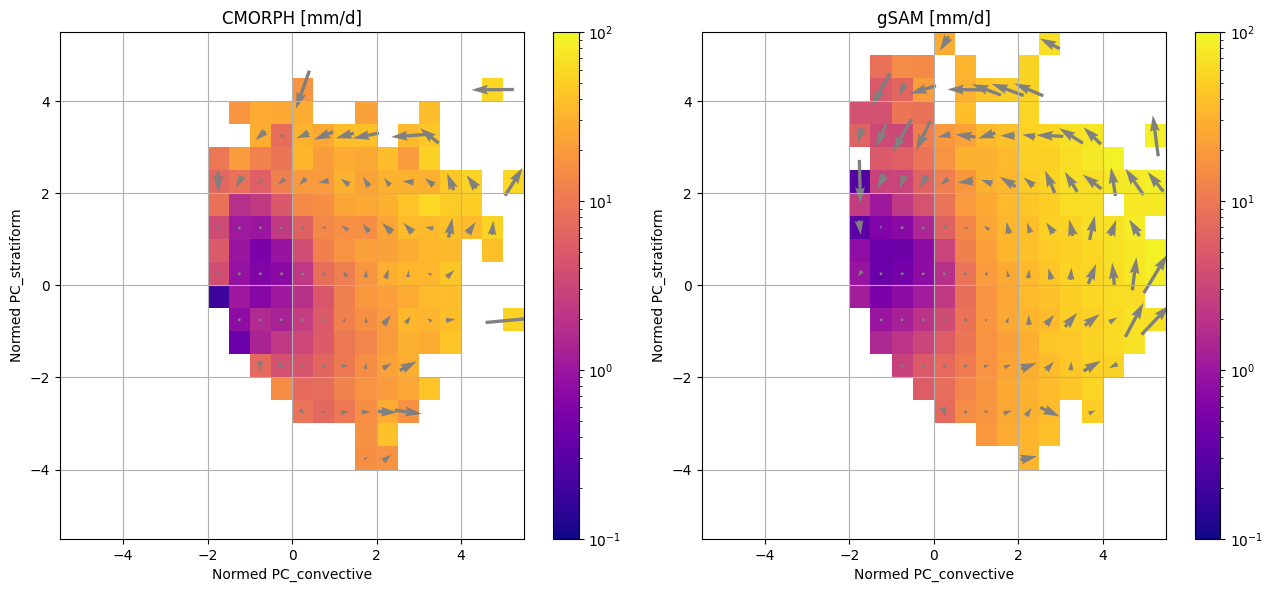

In [114]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(13, 6))

pc1_bins = np.arange(-10, 10, 0.5)
pc2_bins = np.arange(-10, 10, 0.5)
midpoint_pc1_bins = (pc1_bins[1:]+pc1_bins[:-1])/2
midpoint_pc2_bins = (pc2_bins[1:]+pc2_bins[:-1])/2
xmesh, ymesh = np.meshgrid(midpoint_pc1_bins, midpoint_pc2_bins)
normed = True
arrow_space = 2
obs_cutoff=5
for i, ax in enumerate(axs.ravel()):
    pcs = [era5_pcs, gsam_pcs][i]
    dataset = ['CMORPH [mm/d]', 'gSAM [mm/d]'][i]
    precip = [cmorph, gsam_precip][i]
    delta_pcs =  compute_mean_pc_tendency(pcs, 'centered', normed)

    # plot precip
    precip = bin_stat_by_pcs(pcs, precip, pc1_bins, pc2_bins, lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan)

    # overlay mean evolution
    pcs = pcs.sel(time=delta_pcs.time)
    bin_mean_data = dict()
    for mode in [1,2]:
        bin_mean_delta_pc = binned_statistic_2d(
            pcs.sel(mode=2).data.ravel(),
            pcs.sel(mode=1).data.ravel(),
            delta_pcs.sel(mode=mode).data.ravel(),
            statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
            bins=[pc2_bins, pc1_bins]
        ).statistic
        bin_mean_data[mode] = bin_mean_delta_pc
       
    c = ax.pcolormesh(xmesh, ymesh, precip, norm=colors.LogNorm(vmin=1e-1, vmax=1e2), cmap=plt.cm.plasma.copy())

    samp = (slice(None, None, arrow_space), slice(None, None, arrow_space-1))
    ax.quiver(xmesh[samp], ymesh[samp], bin_mean_data[1][samp], bin_mean_data[2][samp], angles='xy', pivot='mid', scale=8, width=0.007, headwidth=3, lw=0.009, edgecolor='black', facecolor='grey')

    ax.set_title(f'{dataset}')
    ax.set_xlabel(rf'Normed PC_convective')
    ax.set_ylabel(rf'Normed PC_stratiform')
    ax.grid()
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    fig.colorbar(c)

plt.tight_layout(pad=1)
plt.savefig(f'{ProjectConfigs().project_root_dir}/figures/gsam_cmorph_precip.pdf', format='pdf')

# Compare Radiative Terms

In [62]:
def gsam_lw_cre(data):
    Flw_cs = data.LWNTC
    Flw_as = data.LWNT
    return(Flw_cs - Flw_as)

def gsam_sw_cre(data):
    Fsw_cs = -data.SWNTC
    Fsw_as = -data.SWNT
    return(Fsw_cs - Fsw_as)


In [92]:
def ceres_lw_cre(data):
    clearsky = data.toa_lw_clr_1h
    allsky = data.toa_lw_all_1h
    return(clearsky-allsky)

def ceres_sw_cre(data):
    clearsky = data.toa_sw_clr_1h
    allsky = data.toa_sw_all_1h
    return(clearsky-allsky)

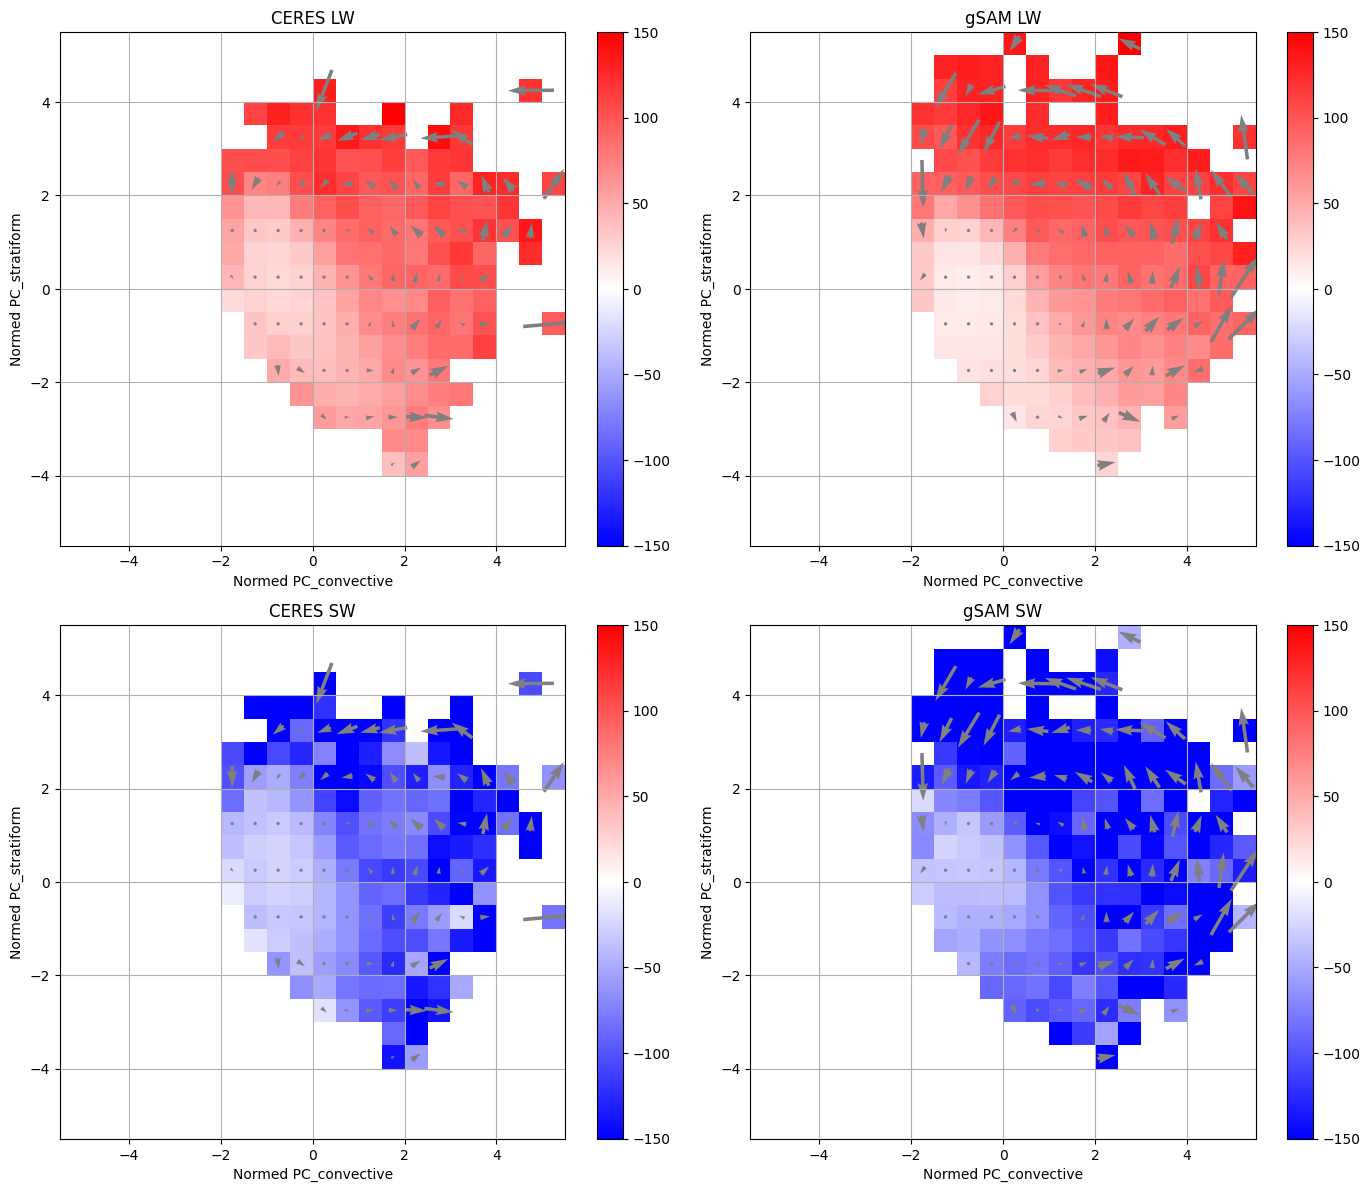

In [115]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 12))
gsam = xr.open_dataset(gSAMConfigs().coarse_var_dir(REGION, '2D', GRIDSIZE)+'/merged.nc')
ceres = xr.open_dataset(CERESConfigs().northwest_tropical_pacific_file)
ceres = ceres.interp(time=era5_pcs.time)
ceres = ceres.coarsen({'lon': 2, 'lat': 2}).mean()
pc1_bins = np.arange(-10, 10, 0.5)
pc2_bins = np.arange(-10, 10, 0.5)
midpoint_pc1_bins = (pc1_bins[1:]+pc1_bins[:-1])/2
midpoint_pc2_bins = (pc2_bins[1:]+pc2_bins[:-1])/2
xmesh, ymesh = np.meshgrid(midpoint_pc1_bins, midpoint_pc2_bins)
normed = True
arrow_space = 2
obs_cutoff=5
for axi, ax in enumerate(axs.ravel()):
    i,j = np.unravel_index(axi, axs.shape)
    pcs = [era5_pcs, gsam_pcs][j]
    dataset = ['Observations [mm/d]', 'gSAM [mm/d]'][i]
    cre_func = [[ceres_lw_cre, ceres_sw_cre], [gsam_lw_cre, gsam_sw_cre]][j][i]
    analysis = [['CERES LW', 'CERES SW'], ['gSAM LW', 'gSAM SW']][j][i]
    delta_pcs =  compute_mean_pc_tendency(pcs, 'centered', normed)

    data = [ceres, gsam][j]

    # plot precip
    cre_data = cre_func(data)
    cre = bin_stat_by_pcs(pcs, cre_data, pc1_bins, pc2_bins, lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan)

    # overlay mean evolution
    pcs = pcs.sel(time=delta_pcs.time)
    bin_mean_data = dict()
    for mode in [1,2]:
        bin_mean_delta_pc = binned_statistic_2d(
            pcs.sel(mode=2).data.ravel(),
            pcs.sel(mode=1).data.ravel(),
            delta_pcs.sel(mode=mode).data.ravel(),
            statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
            bins=[pc2_bins, pc1_bins]
        ).statistic
        bin_mean_data[mode] = bin_mean_delta_pc
       
    c = ax.pcolormesh(xmesh, ymesh, cre, norm=colors.TwoSlopeNorm(vmin=-150, vcenter=0, vmax=150), cmap=plt.cm.bwr.copy())

    samp = (slice(None, None, arrow_space), slice(None, None, arrow_space-1))
    ax.quiver(xmesh[samp], ymesh[samp], bin_mean_data[1][samp], bin_mean_data[2][samp], angles='xy', pivot='mid', scale=8, width=0.007, headwidth=3, lw=0.009, edgecolor='black', facecolor='grey')

    ax.set_title(f'{analysis}')
    ax.set_xlabel(rf'Normed PC_convective')
    ax.set_ylabel(rf'Normed PC_stratiform')
    ax.grid()
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    fig.colorbar(c)

plt.tight_layout(pad=1)
plt.savefig(f'{ProjectConfigs().project_root_dir}/figures/gsam_ceres_cre.pdf', format='pdf')